##Using new complex plane calculations for radial velocity texture
Scott Collis and Jonathan Helmus



In [102]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
import scipy
%matplotlib inline


In [112]:
radar = pyart.io.read('/data/sample_sapr_data/csapr_july9/sgpcsaprsurI7.00.20150709.111301.raw.cfrad.20150709_102911.531_CSAP_v4450_SUR.nc')

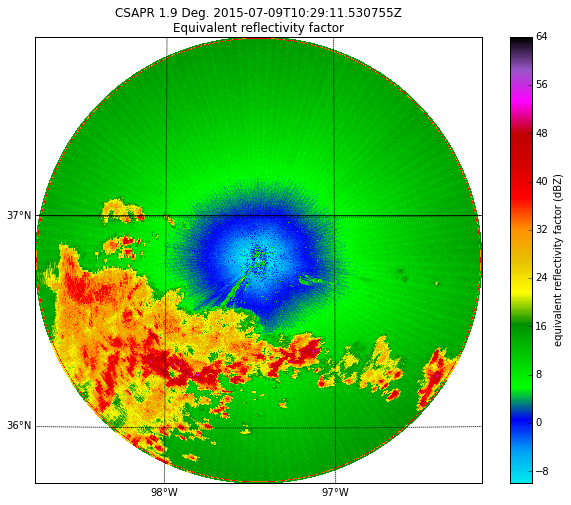

In [3]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 2, resolution = 'i',
                    vmin = -10, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef)


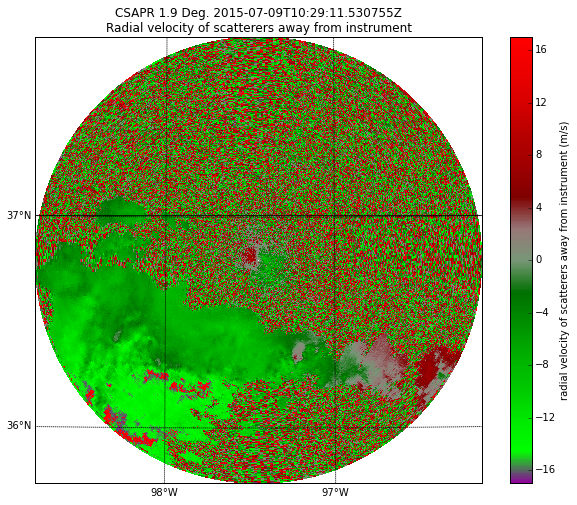

In [101]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity', sweep = 2, resolution = 'i',
                    vmin = -17, vmax = 17, mask_outside = False,
                    cmap = pyart.graph.cm.NWSVel)


In [139]:
nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]

data = scipy.ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                            pyart.util.interval_std, size = (4,4),
                                           extra_arguments = (-nyq, nyq))


In [140]:
filtered_data = scipy.ndimage.filters.median_filter(data, size = (4,4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar.add_field('velocity_texture', texture_field, replace_existing = True)

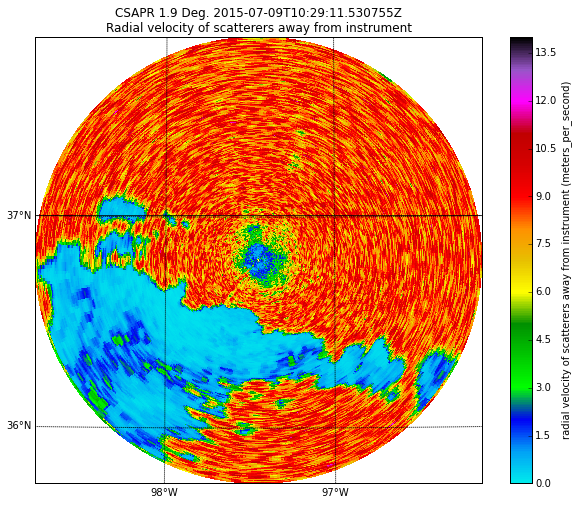

In [199]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('velocity_texture', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = 0, vmax = 14)


In [180]:
n, bins = np.histogram(filtered_data.flatten(), bins = 150)

In [206]:
peaks = scipy.signal.find_peaks_cwt(n, np.array([10]))
centers = bins[0:-1] + (bins[1] - bins[0])
search_data = n[peaks[0]:peaks[1]]
search_centers = centers[peaks[0]:peaks[1]]
locs = search_data.argsort()
location_of_minima = locs[0]

3.99163590734


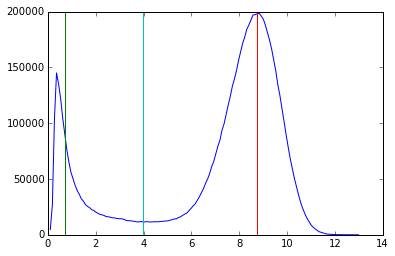

In [212]:
plt.plot(centers, n)
zmax = n.max()
plt.plot([centers[peaks[0]], centers[peaks[0]]], [0, zmax])
plt.plot([centers[peaks[1]], centers[peaks[1]]], [0, zmax])
plt.plot([search_centers[location_of_minima], search_centers[location_of_minima]], [0, zmax])
noise_threshold = search_centers[locs[0]]
print(noise_threshold)

In [213]:
likely_noise = filtered_data > noise_threshold
likely_signal = np.logical_not(likely_noise)


In [214]:
snr = pyart.retrieve.calculate_snr_from_reflectivity(radar)
radar.add_field('SNR', snr, replace_existing = True)

In [215]:
snr_masked = np.ma.masked_where(likely_noise, snr['data'])
#snr_masked[likely_noise] = pyart.config.get_fillvalue()
snr_m_field = pyart.config.get_metadata('SNR')
snr_m_field['data'] = snr_masked
radar.add_field('SNR_masked', snr_m_field, replace_existing = True)



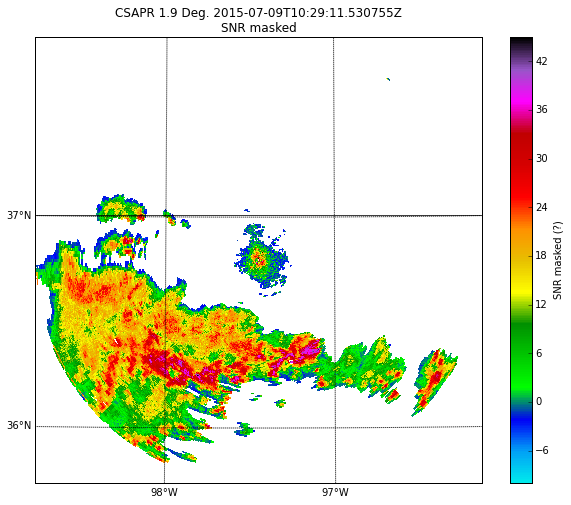

In [216]:
display = pyart.graph.RadarMapDisplay(radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('SNR_masked', sweep = 2, resolution = 'i',
                    mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    vmin = -10, vmax = 45)


In [164]:
def noise_statistics(radar):
    

-9999.0
